# Survival Analysis

In this notebook we conduct survival analysis on the heart failures clinical records dataset. After EDA we discovered that majority of the patients had suffered organ damage - in particular to the heart and kidneys. However, we also discovered that multi-variate analysis didn't result in any significant findings. To confirm whether these attributes play a role in the survival of the patients, we consider conducting survival analysis.

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pingouin as pg
import scipy.stats as stats
from lifelines import KaplanMeierFitter, WeibullFitter, CoxPHFitter
from lifelines.statistics import logrank_test

In [6]:
sns.set_theme(
    style='whitegrid',
    rc={
        'figure.facecolor': '#ffffff',
        'axes.facecolor': '#ffffff',
        'grid.color': 'black',
        'axes.grid.axis' : 'y',
        'grid.linestyle': '-',
        'grid.linewidth': 0.15,
        'axes.edgecolor': 'gray',
        'axes.linewidth': 0.75,
        'xtick.color': '#757575',
        'ytick.color': '#757575',
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'font.family': 'Optima'
    }
)
#Plot here

In [11]:
#set global dpi to 300
plt.rcParams['figure.dpi'] = 150

### Procedure

We will start with survivial analysis using the non-parametric Kaplan Meier Model, from this we will visualize the survival function. Then we will conduct log-rank tests between the following different groups:
- Gender
- Anemia
- Diabetes
- Blood Pressure

This will allow us to confirm whether there is a significant difference in survival between the groups. We will then follow up with a Cox Proportional Hazards Model to observe the hazard functions and hazard rates for different groups. Additionally we can use the Cox PH model to understand how different features affect the hazard rate.

- The time to event column will be the `time` column
- The censor column will be the `death` column

The data has had some processing done to it, the processing includes:
- Renaming columns.
- A disease column was created which counts how many diseases a patient has.

It is important to note that a significant amount of data is censored (i.e. the patient is still alive at the end of the study). This is important to consider when interpreting the results.

In [67]:
heart_data = pd.read_csv('./heart_data_processed.csv')
heart_data.head()

,age,anemia,cpk,diabetes,ejection_fraction,bp,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death,disease,cpk_log
0,75.0,0,582,0,20,1,265000.00,1.9,130,male,0,4,1,1,6.366470
1,55.0,0,7861,0,38,0,263358.03,1.1,136,male,0,6,1,0,8.969669
2,65.0,0,146,0,20,0,162000.00,1.3,129,male,1,7,1,0,4.983607
3,50.0,1,111,0,20,0,210000.00,1.9,137,male,0,7,1,1,4.709530
4,65.0,1,160,1,20,0,327000.00,2.7,116,female,0,8,1,2,5.075174


### Survival Analysis with Kaplan Meier

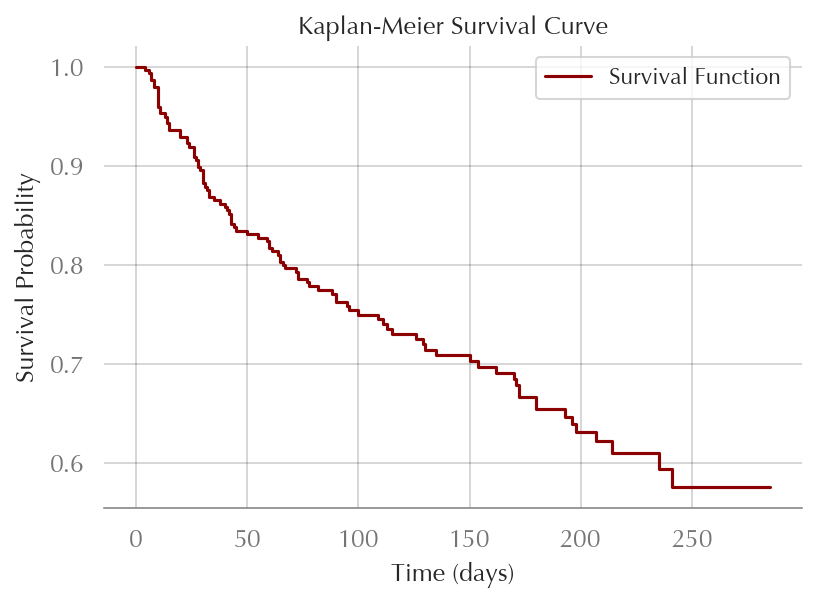

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))

km_model = KaplanMeierFitter()
km_model.fit(heart_data['time'], heart_data['death'])

km_model.plot(ci_show=False, color='darkred', ax=ax)
ax.set_title('Kaplan-Meier Survival Curve')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival Probability')
ax.legend(['Survival Function'])
sns.despine(left=True, right=True, top=True)
plt.show()

- The survival function shows that beyond 250 days, the survival probability flattens out at 50%, this isn't surprising considering the majority of patients were alive at the end of the study.
- This has the implication that the median survival time can not be determined.

In [21]:
every_10_days = np.arange(0, 251, 14)
s_times = km_model.survival_function_at_times(every_10_days)

Now we will plot separate survival curves for each of the groups.

In [43]:
anemic = heart_data[heart_data['anemia'] == 1]
non_anemic = heart_data[heart_data['anemia'] == 0]

diabetic = heart_data[heart_data['diabetes'] == 1]
non_diabetic = heart_data[heart_data['diabetes'] == 0]

high_blood_pressure = heart_data[heart_data['bp'] == 1]
non_high_blood_pressure = heart_data[heart_data['bp'] == 0]

#get males using loc
males = heart_data.loc[heart_data['sex'] == 'male']
femailes = heart_data.loc[heart_data['sex'] == 'female']

#no disease
no_disease = heart_data[heart_data['disease'] == 0]
with_disease = heart_data[heart_data['disease'] > 1]

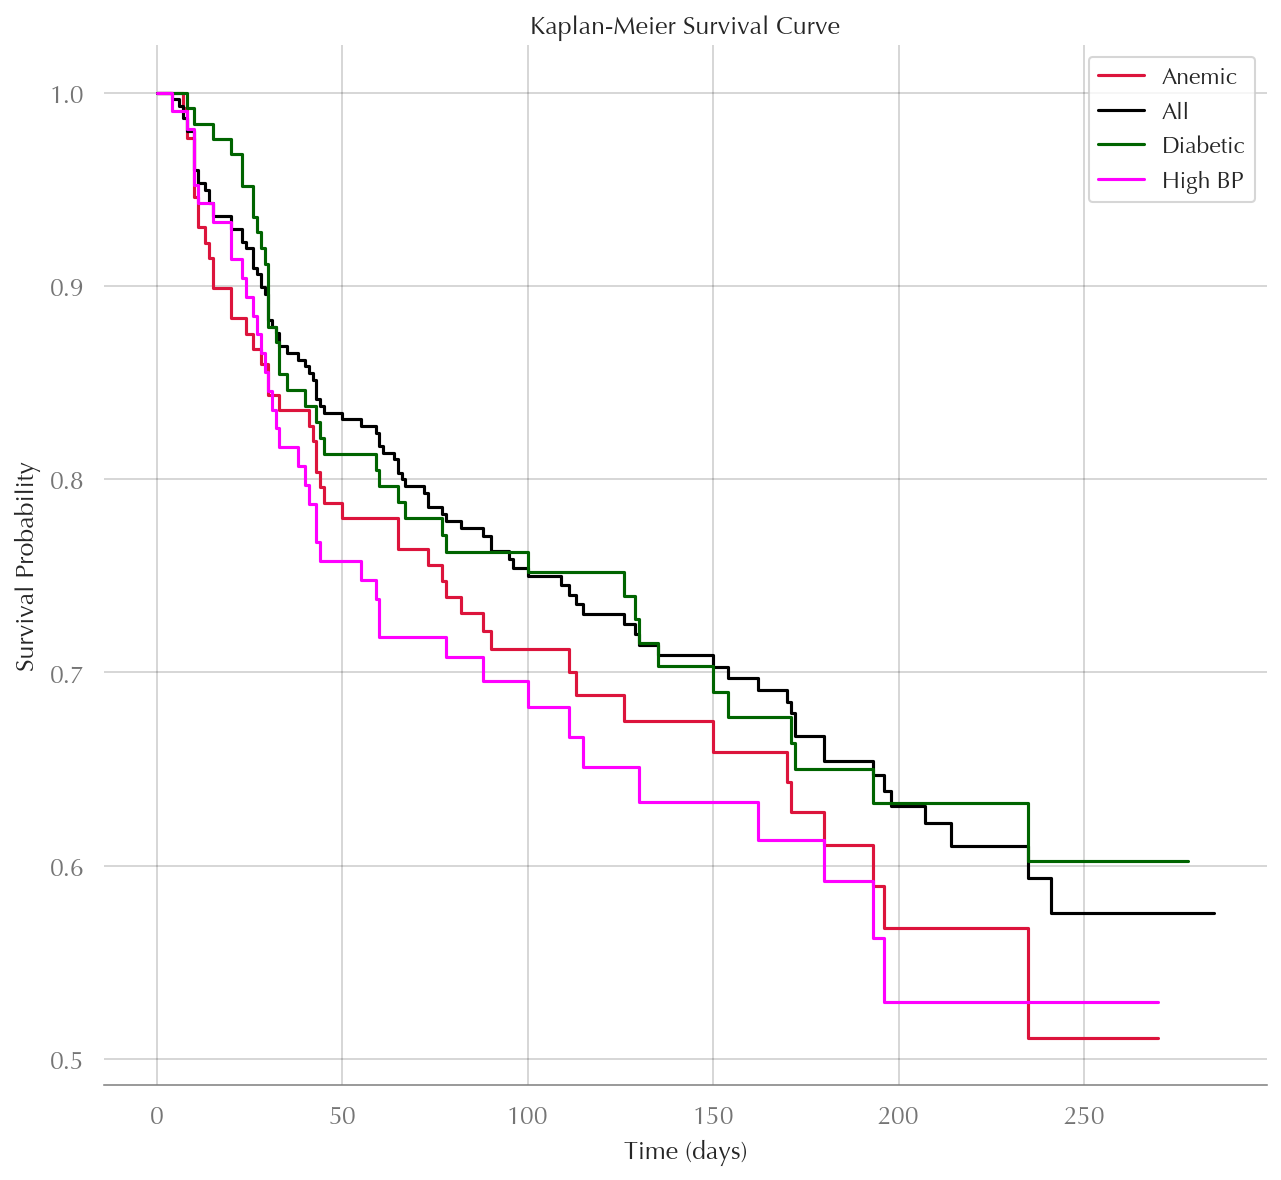

In [36]:
#plot survival curves for each group
fig, ax = plt.subplots(figsize=(10, 9))

km_model.fit(anemic['time'], anemic['death'])
km_model.plot(ci_show=False, color='crimson', ax=ax)
km_model.fit(heart_data['time'], heart_data['death'])
km_model.plot(ci_show=False, color='black', ax=ax)
km_model.fit(diabetic['time'], diabetic['death'])
km_model.plot(ci_show=False, color='darkgreen', ax=ax)
km_model.fit(high_blood_pressure['time'], high_blood_pressure['death'])
km_model.plot(ci_show=False, color='fuchsia', ax=ax)


ax.set_title('Kaplan-Meier Survival Curve')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival Probability')
ax.legend(['Anemic', 'All', 'Diabetic', 'High BP'])
sns.despine(left=True, right=True, top=True)
plt.show()

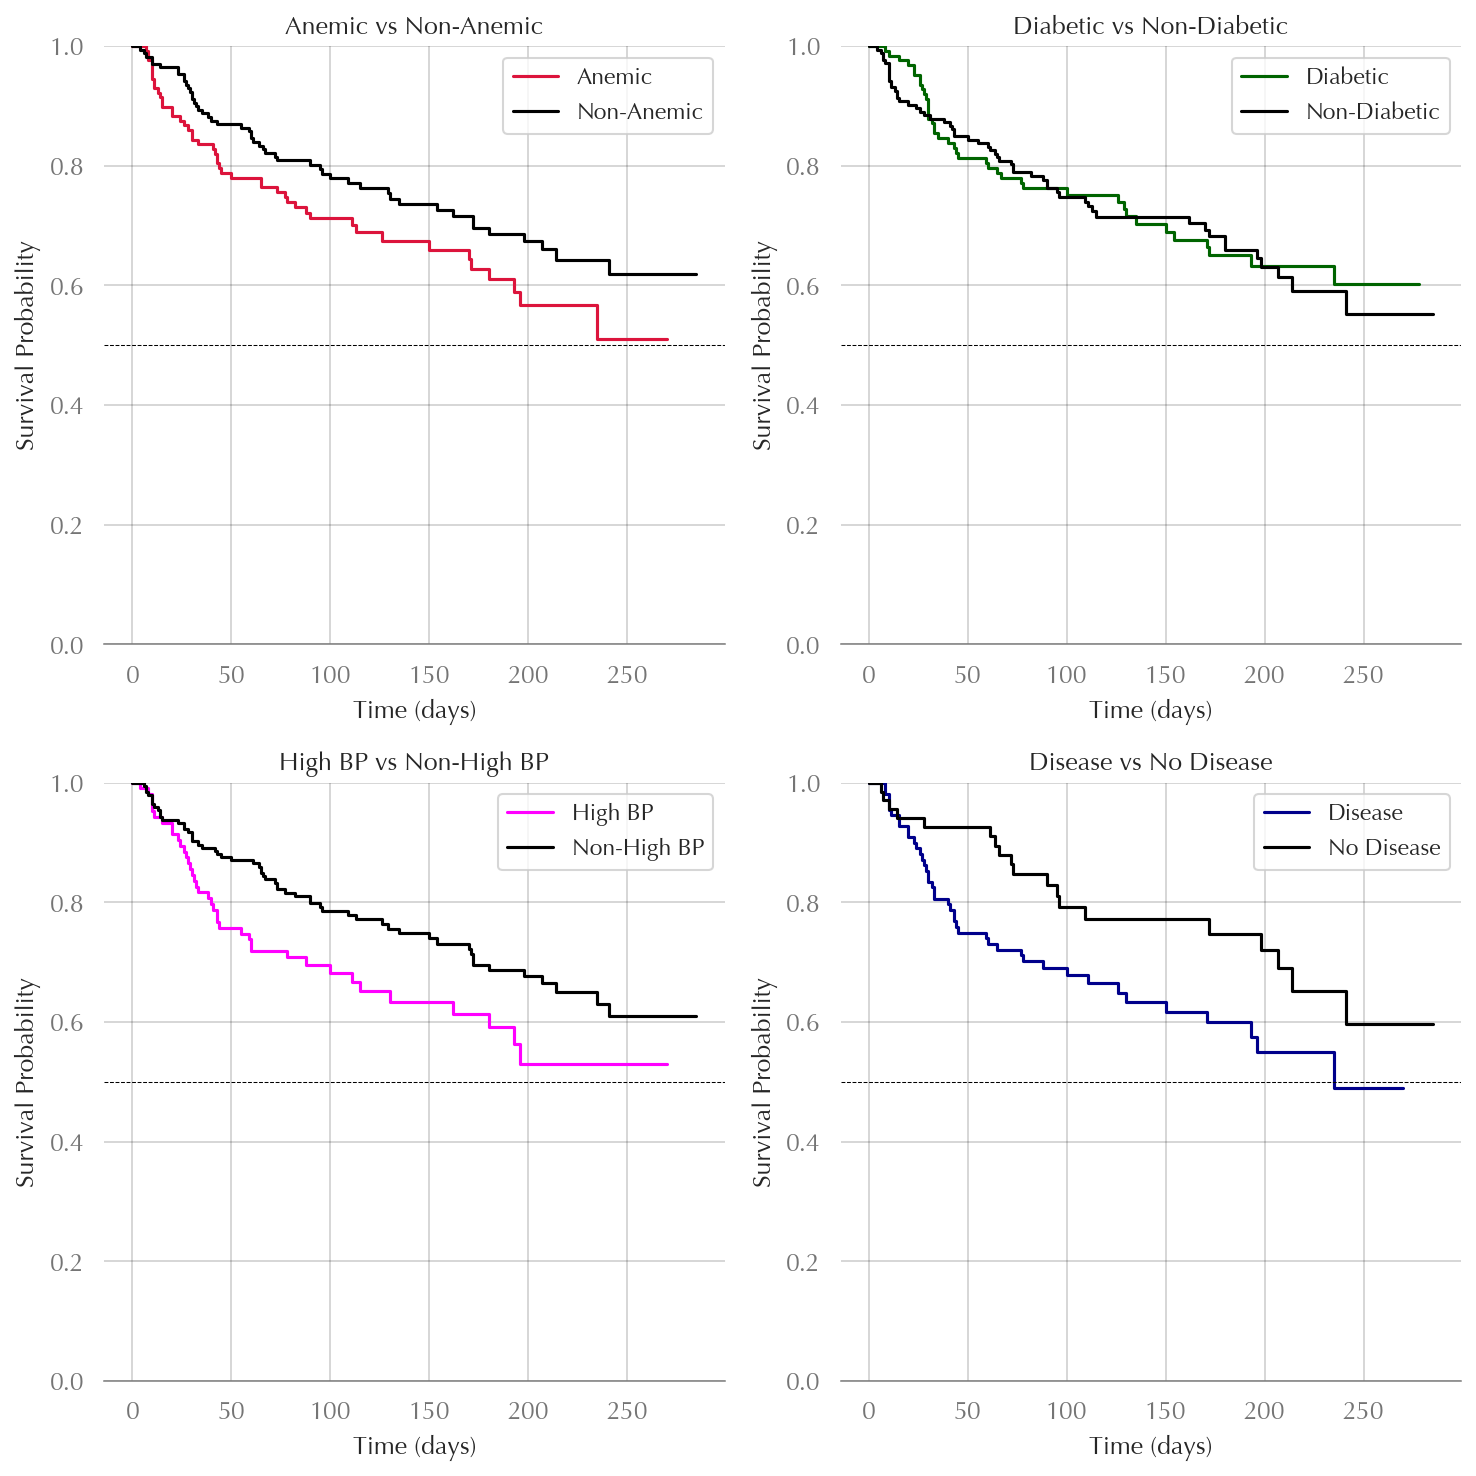

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

#anemic vs non anemic
km_model.fit(anemic['time'], anemic['death'])
km_model.plot(ci_show=False, color='crimson', ax=ax[0, 0])
km_model.fit(non_anemic['time'], non_anemic['death'])
km_model.plot(ci_show=False, color='black', ax=ax[0, 0])

#diabetic vs non diabetic
km_model.fit(diabetic['time'], diabetic['death'])
km_model.plot(ci_show=False, color='darkgreen', ax=ax[0, 1])
km_model.fit(non_diabetic['time'], non_diabetic['death'])
km_model.plot(ci_show=False, color='black', ax=ax[0, 1])

#high bp vs non high bp
km_model.fit(high_blood_pressure['time'], high_blood_pressure['death'])
km_model.plot(ci_show=False, color='fuchsia', ax=ax[1, 0])
km_model.fit(non_high_blood_pressure['time'], non_high_blood_pressure['death'])
km_model.plot(ci_show=False, color='black', ax=ax[1, 0])

#all disease against no disease
km_model.fit(with_disease['time'], with_disease['death'])
km_model.plot(ci_show=False, color='darkblue', ax=ax[1, 1])
km_model.fit(no_disease['time'], no_disease['death'])
km_model.plot(ci_show=False, color='black', ax=ax[1, 1])

ax[0, 0].set_title('Anemic vs Non-Anemic')
ax[0, 0].set_xlabel('Time (days)')
ax[0, 0].set_ylabel('Survival Probability')
ax[0, 0].legend(['Anemic', 'Non-Anemic'])
ax[0, 0].set_ylim([0, 1])

ax[0, 1].set_title('Diabetic vs Non-Diabetic')
ax[0, 1].set_xlabel('Time (days)')
ax[0, 1].set_ylabel('Survival Probability')
ax[0, 1].legend(['Diabetic', 'Non-Diabetic'])
ax[0, 1].set_ylim([0, 1])

ax[1, 0].set_title('High BP vs Non-High BP')
ax[1, 0].set_xlabel('Time (days)')
ax[1, 0].set_ylabel('Survival Probability')
ax[1, 0].legend(['High BP', 'Non-High BP'])
ax[1, 0].set_ylim([0, 1])

ax[1, 1].set_title('Disease vs No Disease')
ax[1, 1].set_xlabel('Time (days)')
ax[1, 1].set_ylabel('Survival Probability')
ax[1, 1].legend(['Disease', 'No Disease'])
ax[1, 1].set_ylim([0, 1])

#add h lines at 0.5 for each plot
ax[0, 0].axhline(0.5, color='black', linestyle='--', linewidth=0.5)
ax[0, 1].axhline(0.5, color='black', linestyle='--', linewidth=0.5)
ax[1, 0].axhline(0.5, color='black', linestyle='--', linewidth=0.5)
ax[1, 1].axhline(0.5, color='black', linestyle='--', linewidth=0.5)

sns.despine(left=True, right=True, top=True)

plt.tight_layout()
plt.show()

- The survival curves for each group are similar, but it can be clearly seen that patients with high blood pressure have a lower survival probability than those with normal blood pressure for a given time interval.
- Patients with anemia also have a lower survival probability.
- Patients with diabetes tend to have a simlar survival probability to those without.
- The grouped plot below shows that being aflicted by a condition visible decreases the survival probability.

We will follow these plots up with log-rank tests to determine whether there is a significant difference in survival between the groups. For this we will use a significance level $\alpha$ of 0.01.

In [51]:
#log rank tests between groups
#anemic vs non anemic
log_rank = logrank_test(anemic['time'], non_anemic['time'], anemic['death'], non_anemic['death'])
print('Anemic vs Non-Anemic p-value')
print(log_rank.p_value)

#diabetic vs non diabetic
log_rank = logrank_test(diabetic['time'], non_diabetic['time'], diabetic['death'], non_diabetic['death'])
print('Diabetic vs Non-Diabetic p-value')
print(log_rank.p_value)

#high bp vs non high bp
log_rank = logrank_test(high_blood_pressure['time'], non_high_blood_pressure['time'], high_blood_pressure['death'], non_high_blood_pressure['death'])
print('High BP vs Non-High BP p-value')
print(log_rank.p_value)

#all disease against no disease
log_rank = logrank_test(with_disease['time'], no_disease['time'], with_disease['death'], no_disease['death'])
print('Disease vs No Disease p-value')
print(log_rank.p_value)

Anemic vs Non-Anemic p-value
0.09869758380739609
Diabetic vs Non-Diabetic p-value
0.8404519853946042
High BP vs Non-High BP p-value
0.035807524286923936
Disease vs No Disease p-value
0.05840671736810824


- The log rank test shows that none of the groups have a significant difference in survival probability.
- Diabetes very clearly has no significance whatsoever with an extremly large p-value.
- The other groups have p-values that are very close to the significance level, but they are still above it.

### Cox Proportional Hazards Model

While survival analysis using the Kaplan Meier model and the log rank test can lead to determine whether or not a particular group has a significant difference in survival, it does so without considering the effect of other variables. The Cox PH model allows us to consider the effect of other variables on the survival probability, this also includes the numerical features. Moreover, the Cox PH model allows us to determine the instantaneous hazard rate for each group, and a specific individual.

First the data needs to be prepocessed namely, the categorical variables need to be binary encoded, in particular the `sex` variable.

To determine if any covariate is significant, we will use a significance level $\alpha$ of 0.05.

In [75]:
gender_map = {
    'male' : 1,
    'female' : 0
}

heart_data_processed = heart_data.copy()
heart_data_processed['sex'] = heart_data_processed['sex'].map(gender_map)

In [76]:
heart_data_processed = heart_data_processed.drop(['cpk_log', 'disease'], axis=1)

In [77]:
heart_data_processed

,age,anemia,cpk,diabetes,ejection_fraction,bp,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [79]:
#fit cox proportional hazard model
cph_model = CoxPHFitter()
cph_model.fit(heart_data_processed, 'time', event_col='death')
cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -468.23
         time fit was run = 2023-11-21 12:15:44 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
age                 0.05       1.05       0.01             0.03             0.06                 1.03                 1.07
anemia              0.46       1.58       0.22             0.04             0.89                 1.04                 2.42
cpk                 0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
diabetes            0.14       1.15       0.22            -0.30             0.58                 0.74                 1.78
ejection_fraction  -0.05       0.95       0.01            -0.07            -0.03                 0.93                 0.97
bp                  0.48       1.61       0.22             0.05             0.90                 1.05                 2.46
platelets          -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
serum_creatinine    0.32       1.38       0.07             0.18             0.46                 1.20                 1.58
serum_sodium       -0.04       0.96       0.02            -0.09             0.00                 0.91                 1.00
sex                -0.24       0.79       0.25            -0.73             0.26                 0.48                 1.29
smoking             0.13       1.14       0.25            -0.36             0.62                 0.70                 1.86

                    cmp to     z      p   -log2(p)
covariate                                         
age                   0.00  4.98 <0.005      20.56
anemia                0.00  2.12   0.03       4.89
cpk                   0.00  2.23   0.03       5.26
diabetes              0.00  0.63   0.53       0.91
ejection_fraction     0.00 -4.67 <0.005      18.35
bp                    0.00  2.20   0.03       5.17
platelets             0.00 -0.41   0.68       0.56
serum_creatinine      0.00  4.58 <0.005      17.68
serum_sodium          0.00 -1.90   0.06       4.12
sex                   0.00 -0.94   0.35       1.53
smoking               0.00  0.51   0.61       0.72
---
Concordance = 0.74
Partial AIC = 958.46
log-likelihood ratio test = 81.95 on 11 df
-log2(p) of ll-ratio test = 40.56

The analysis of the Cox PH model sheds some important insights.
- The results show that a 1 year increase in age results in a 5% increase in the hazard rate. This appears to be a statistically significant variable as it has a p-value of <0.005.
- Conversely, a 1% decrease in ejection fraction also results in a 5% increase in the hazard rate. This is also a statistically significant variable as it has a p-value of <0.005.
- Surprisingly, serum_creatinine appears to impact the hazard rate the most, with a 1 unit increase resulting in a 38% increase in the hazard rate. This is also a statistically significant variable as it has a p-value of <0.005.
- Using the larger significance level of 0.05, we can see that anemia, and high blood pressure also result in large increases in the hazard rate. 
    - Anemia results in a 58% increase
    - High blood pressure results in a 61% increase
    - Both of these variables have p-values of 0.03.

Let us remove the redundant variables and re-run the model with the features that displayed significance. Before doing so we will visualize the partial effects for serum_creatinine.

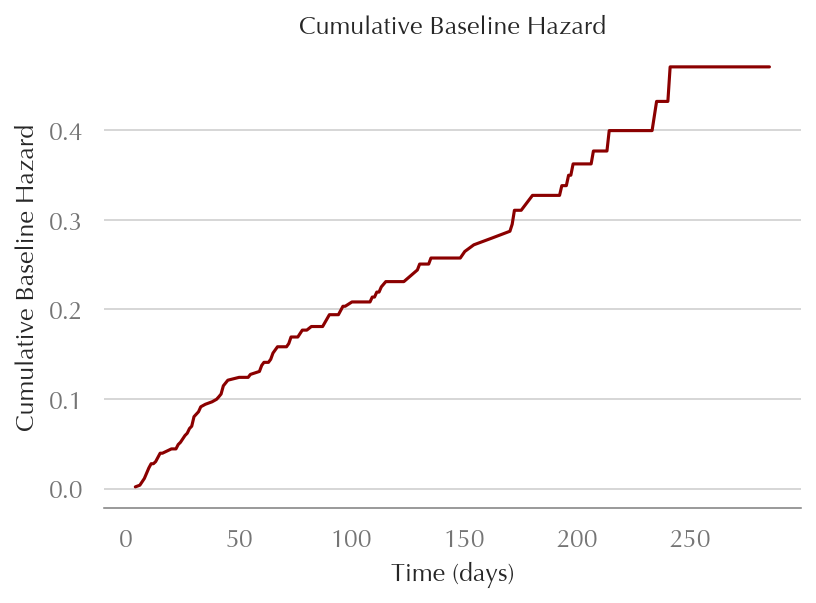

In [90]:
cumulative_baseline_hazard = cph_model.baseline_cumulative_hazard_

#plot cumulative baseline hazard
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(cumulative_baseline_hazard.index, cumulative_baseline_hazard, color='darkred')
ax.set_title('Cumulative Baseline Hazard')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Cumulative Baseline Hazard')
sns.despine(left=True, right=True, top=True)
plt.show()

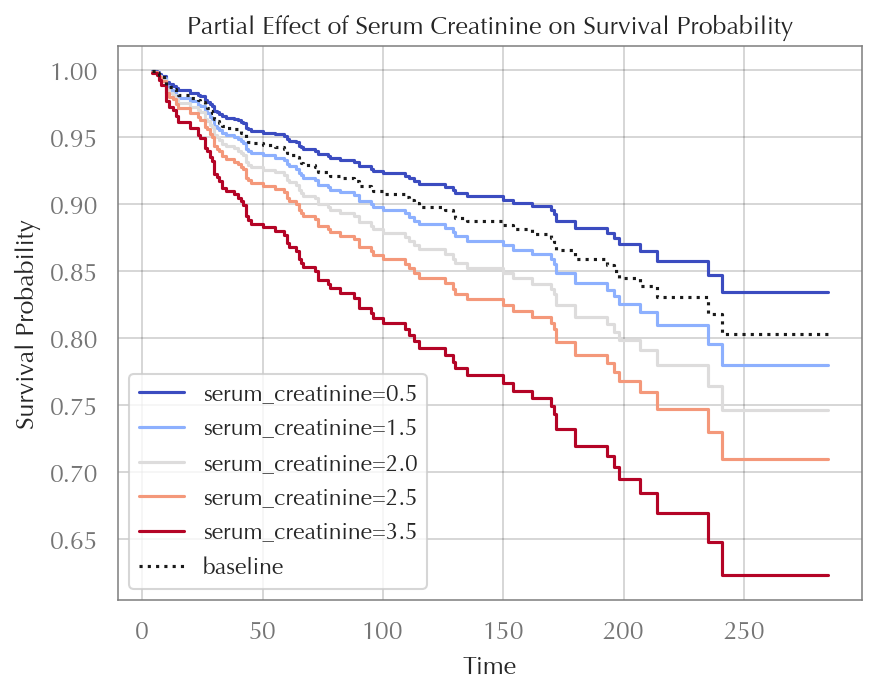

In [94]:
cph_model.plot_partial_effects_on_outcome('serum_creatinine', [0.5,1.5,2.0, 2.5,3.5], cmap='coolwarm')
#label axes
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Partial Effect of Serum Creatinine on Survival Probability')
plt.show()

- Higher levels of serum_creatinine clearly result in a steep decline in survival probability, when varied with time.
- Surprisingly, lower levels of serum_creatinine result in a slight increase in survival probability.

#### Cox PH Model with Significant Features

In [95]:
cph_sig = CoxPHFitter()
cph_sig.fit(heart_data_processed, 'time', event_col='death', formula="age + bp + anemia + serum_creatinine + ejection_fraction")
cph_sig.print_summary()

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -472.29
         time fit was run = 2023-11-21 12:44:11 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
age                 0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
bp                  0.45       1.57       0.21             0.03             0.87                 1.03                 2.38
anemia              0.33       1.39       0.21            -0.08             0.74                 0.93                 2.10
serum_creatinine    0.34       1.40       0.07             0.21             0.47                 1.23                 1.60
ejection_fraction  -0.05       0.95       0.01            -0.07            -0.03                 0.93                 0.97

                    cmp to     z      p   -log2(p)
covariate                                         
age                   0.00  4.84 <0.005      19.56
bp                    0.00  2.11   0.03       4.86
anemia                0.00  1.60   0.11       3.18
serum_creatinine      0.00  5.15 <0.005      21.89
ejection_fraction     0.00 -5.10 <0.005      21.52
---
Concordance = 0.73
Partial AIC = 954.58
log-likelihood ratio test = 73.83 on 5 df
-log2(p) of ll-ratio test = 45.80

When solely considering the significant features, the p-value for the significance of anemia has shot up to 0.11. However, the p-value for the other feautures still remains below 0.05, this suggests that these features may be actual indicators of mortality.

## Conclusion

Contrary to the exploratory data analysis, the survival and hazard analysis has shown that certain features such as age, and even high blood pressure when considered alongside time lead to an increase in the hazard rate. This suggests that these features may be indicators of mortality. 